In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, InputLayer, Dropout, Reshape
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Load the dataset
df = pd.read_csv("dataset.csv")
df.index = pd.to_datetime(df["id"], errors="ignore")

# Columns for training
cols = [
    "humid",
    "ws100",
    "wdisp100",
    "vertdisp100",
]
df_for_training = df[cols].astype(float)

# StandardScaler for normalization
scaler = StandardScaler()
df_for_training_scaled = scaler.fit_transform(df_for_training)

# Define sequence and prediction lengths
sequence_length = 36  # Last 6 hours (36 values)
prediction_length = 6  # Next 1 hour (6 values)

X, y = [], []

# Prepare sequences for input and output
for i in range(len(df_for_training_scaled) - sequence_length - prediction_length + 1):
    X.append(df_for_training_scaled[i: i + sequence_length])
    y.append(df_for_training_scaled[i + sequence_length: i + sequence_length + prediction_length])

X = np.array(X)
y = np.array(y)

print(f"Shape of X: {X.shape}")  # (samples, 36, features)
print(f"Shape of y: {y.shape}")  # (samples, 6, features)


2024-10-31 15:50:47.734565: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730400647.840663    2048 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730400647.868275    2048 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-31 15:50:48.105863: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Shape of X: (7520, 36, 4)
Shape of y: (7520, 6, 4)


/tmp/ipykernel_2048/4213969432.py:12: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  df.index = pd.to_datetime(df["id"], errors="ignore")


In [2]:
# Manual train-test split
train_size = int(len(X) * 0.8)
X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]


In [3]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the model
model1 = Sequential()
model1.add(InputLayer(input_shape=(sequence_length, len(cols))))
model1.add(LSTM(128))
model1.add(Dropout(0.15))  # Dropout layer for regularization
model1.add(Dense(prediction_length * len(cols), activation='linear'))
model1.add(Reshape((prediction_length, len(cols))))

model1.compile(optimizer="adam", loss="mse")

# Callbacks for saving the best model and early stopping
cp1 = ModelCheckpoint("model1.keras", save_best_only=True)
es = EarlyStopping(monitor='val_loss', patience=5)

# Measure training time
start_time = time.time()

# Training
model1.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    callbacks=[cp1, es],
    verbose=1
)

end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {training_time:.2f} seconds")


/home/lucas/Projetos/TFG-Vento-Sul/.venv/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
I0000 00:00:1730400651.141921    2048 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5564 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:06:00.0, compute capability: 8.6


Epoch 1/50


I0000 00:00:1730400653.262038    2245 cuda_dnn.cc:529] Loaded cuDNN version 90300


188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.4465 - val_loss: 0.2721
Epoch 2/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.2480 - val_loss: 0.2609
Epoch 3/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.2275 - val_loss: 0.2498
Epoch 4/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.2209 - val_loss: 0.2533
Epoch 5/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.2133 - val_loss: 0.2570
Epoch 6/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.2127 - val_loss: 0.2540
Epoch 7/50
 10/188 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.1920

KeyboardInterrupt: 

In [ ]:
# Model summary for computational metrics
model1.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 128)            │        68,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 24)             │         3,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 6, 4)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 213,578 (834.29 KB)

 Trainable params: 71,192 (278.09 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 142,386 (556.20 KB)

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
'humid': RMSE = 3.4319, NRMSE = 0.0903, Relative Error = 3.09%


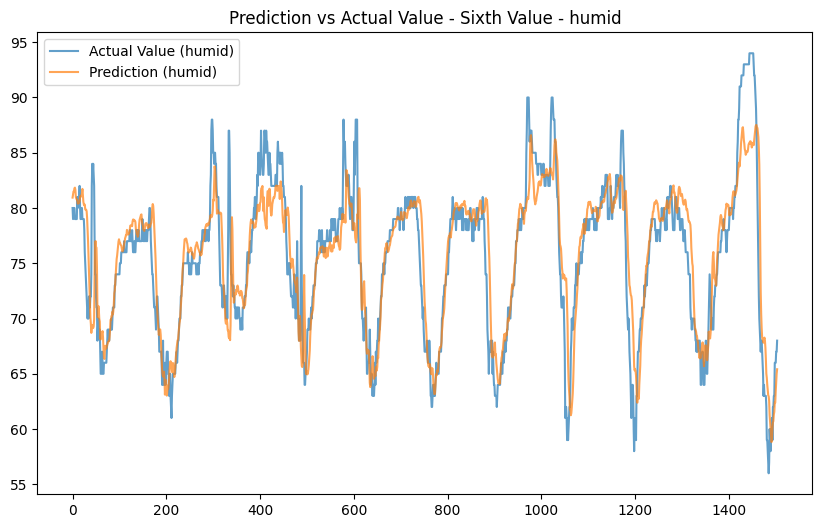

'ws100': RMSE = 0.9940, NRMSE = 0.1022, Relative Error = 10.43%


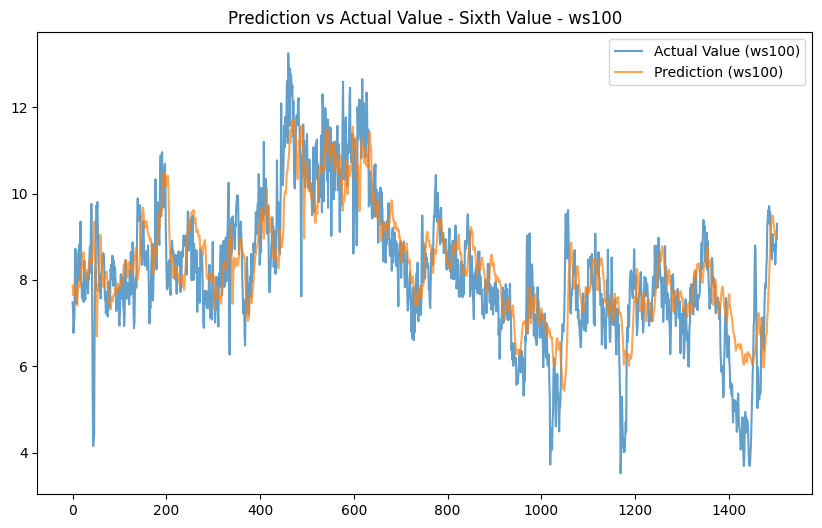

'wdisp100': RMSE = 0.2062, NRMSE = 0.0986, Relative Error = 22.83%


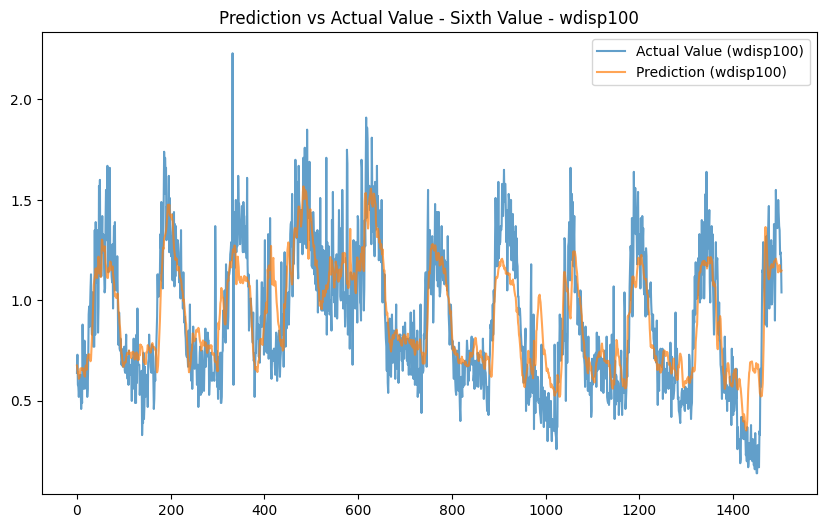

'vertdisp100': RMSE = 0.1799, NRMSE = 0.0807, Relative Error = 30.55%


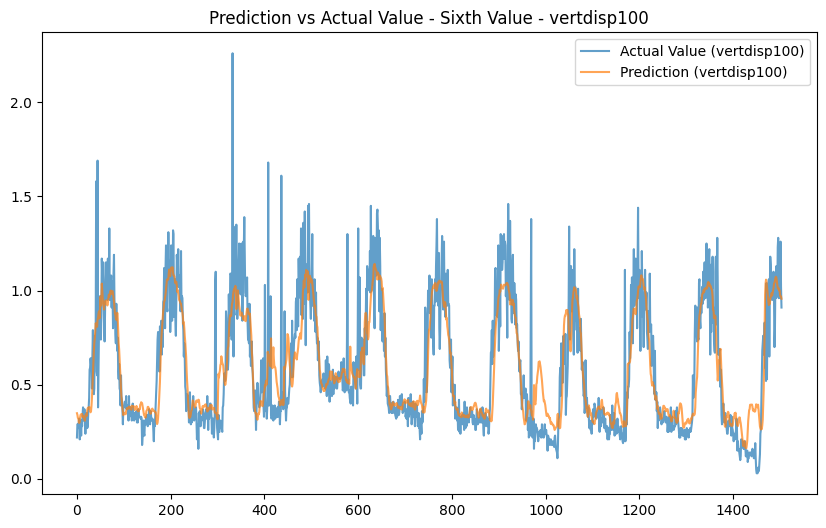


Correlation of each variable with 'ws100':
humid         -0.433935
ws100          1.000000
wdisp100       0.558741
vertdisp100    0.365820
Name: ws100, dtype: float64


In [ ]:
# Make predictions
y_pred = model1.predict(X_test)

# Inverse transform to original scale
y_pred_orig = y_pred.reshape(-1, len(cols))
y_pred_orig = scaler.inverse_transform(y_pred_orig)
y_pred_orig = y_pred_orig.reshape(-1, prediction_length, len(cols))

y_test_orig = y_test.reshape(-1, len(cols))
y_test_orig = scaler.inverse_transform(y_test_orig)
y_test_orig = y_test_orig.reshape(-1, prediction_length, len(cols))

# Evaluate the sixth predicted value
for i, col in enumerate(cols):
    # Extract the sixth predicted value
    y_true = y_test_orig[:, 5, i]  # Sixth value (index 5)
    y_pred_col = y_pred_orig[:, 5, i]

    # RMSE and NRMSE
    rmse = np.sqrt(np.mean((y_true - y_pred_col) ** 2))
    nrmse = rmse / (y_true.max() - y_true.min())

    # Mean relative error
    relative_error = (
        np.mean(np.abs((y_true - y_pred_col) / y_true)) * 100
    )

    print(
        f"'{col}': RMSE = {rmse:.4f}, NRMSE = {nrmse:.4f}, Relative Error = {relative_error:.2f}%"
    )

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(y_true, label=f"Actual Value ({col})", alpha=0.7)
    plt.plot(y_pred_col, label=f"Prediction ({col})", alpha=0.7)
    plt.legend()
    plt.title(f"Prediction vs Actual Value - Sixth Value - {col}")
    plt.show()

# Correlation matrix
correlations = df_for_training.corr(method="pearson")
print("\nCorrelation of each variable with 'ws100':")
print(correlations["ws100"])
